In [ ]:
!pip install graphviz

In [ ]:
!pip install pydot

# Malaria Cells Images Classification

In [1]:
import os
import glob
import gc
import time
import datetime
import sys
from pathlib import Path
#Data manipulation
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
#Plotting
import cv2 as cv2
from skimage import feature
#Scientific
from scipy import stats
#Machine learning
import multiprocessing
import joblib
from joblib import parallel_backend
#from sklearn.externals.joblib import parallel_backend
from sklearn.utils import shuffle
from sklearn.model_selection import train_test_split
from sklearn.manifold import TSNE
from sklearn.decomposition import PCA
from sklearn import svm, datasets
from sklearn.ensemble import RandomForestClassifier, VotingClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.metrics import accuracy_score, confusion_matrix, classification_report
from sklearn.model_selection import GridSearchCV
#cnn
import keras
from keras.utils import np_utils
from keras.models import Sequential
from keras import optimizers
from keras import callbacks
from keras import preprocessing
from keras.preprocessing.image import ImageDataGenerator
from keras.layers import Conv2D, MaxPooling2D, Dense, Flatten, Dropout, BatchNormalization
from keras.callbacks import ModelCheckpoint, EarlyStopping, TensorBoard, ReduceLROnPlateau
from keras.engine.training import Model
from keras.utils import plot_model


In [2]:
import pydot
import graphviz
from keras.utils.vis_utils import plot_model
from keras.utils.vis_utils import model_to_dot
keras.utils.vis_utils.pydot = pydot

### Image Processing

A BGR image is processed in this way:

binary_mask: Contour mask optained by thresholding the original grayscale image

binary_green: special thresholding of green channel in order to highlight defects

erosion: binary_mask is eroded to make border thin. (clean subtraction)

green_diff: binary_green is subtracted from binary_mask leaving only defects

grenn_diff_canny: canny edge detector applied to green_diff

green_contast: green channel with more contrast

Return: tuple of 3 element (green_diff, green_diff_canny, green_contrast)

In [3]:
def process_image(image_BGR, label, show):
    binary_mask = cv2.split(image_BGR)[0]
    ret, binary_mask = cv2.threshold(binary_mask, 10, 255, cv2.THRESH_BINARY)
    ret, binary_green = cv2.threshold(cv2.split(image_BGR)[1], 100, 255, cv2.THRESH_BINARY)
    kernel = np.ones((3,3),np.uint8)
    binary_mask = cv2.erode(binary_mask, kernel, iterations = 1)
    green_diff = cv2.subtract(binary_mask, binary_green)
    green_diff_canny = cv2.Canny(green_diff, 40, 40)
    green = cv2.split(image_BGR)[1]
    clahe = cv2.createCLAHE(clipLimit=3.0, tileGridSize=(8,8))
    green_contrast = clahe.apply(green)

    ########### PLOTTING ###########
    def plot_subfigures(rows, columns, index, image, isColor, title):
        plt.subplot(rows, columns, index)
        plt.subplots_adjust(hspace=0.5, wspace=0.5)
        if isColor:
            plt.imshow(cv2.cvtColor(image, cv2.COLOR_BGR2RGB))
        else :
            plt.imshow(image, cmap='gray')
        plt.title('{}'.format(title))
        plt.xticks([]), plt.yticks([])  # to hide tick values on X and Y axis
    if show:
        plt.figure(1, figsize=(10, 5))
        plt.suptitle("Preprocessing Uninfected cell" if label == 0 else "Preprocessing Infected cell")
        #Sub figures
        plot_subfigures(2, 4, 1, image_BGR, True, "Original")
        plot_subfigures(2, 4, 2, binary_mask, False, "Binary Mask")
        plot_subfigures(2, 4, 3, binary_green, False, "Binary Green")
        plot_subfigures(2, 4, 4, green_diff, False, "Green diff")
        plot_subfigures(2, 4, 5, green_diff_canny, False, "Green diff Canny")
        plot_subfigures(2, 4, 6, green_contrast, False, "Green Contrast")
        plt.savefig(figure_directory + "cells_processing.pdf")
        plt.show()
    return (green_diff, green_diff_canny, green_contrast)

### Input/Output Configuration

Configuring input and loading images into memory

Configuring output folders and paths for future store

In [4]:
############# INPUT CONFIGURATION ###########
dataset_base_directory = "C://Users//bhoom//Desktop//Projects//Untitled Folder 1//cell_images"
cells_folders = os.listdir(dataset_base_directory)
print("Cells folders:", cells_folders)
infected_folder = dataset_base_directory + "/Parasitized"
uninfected_folder = dataset_base_directory + "/Uninfected"
infected_images = glob.glob(infected_folder + "/*.png")
uninfected_images = glob.glob(uninfected_folder + "/*.png")
infected_number = len(infected_images)
uninfected_number = len(uninfected_images)
print('# Infected fotos: ', infected_number)
print('# Infected fotos: ', uninfected_number)

############# OUTPUT CONFIGURATION ###########
def create_new_folder(directory):
    if not os.path.exists(directory):
        try:
            os.mkdir(directory)
        except:
            print("Could not create {} directory".format(directory))
output_directory = r"output/"
figure_directory = "output/figures/"
models_directory = output_directory + r"models/"
classifiers_directory = output_directory + r"classifiers/"
logs_directory = output_directory + r"logs/"
model_directory = models_directory + time.strftime('%Y-%m-%d %H-%M-%S') + "/"
log_directory = logs_directory + time.strftime('%Y-%m-%d %H-%M-%S') + "/"

create_new_folder(output_directory)
create_new_folder(figure_directory)
create_new_folder(models_directory)
create_new_folder(logs_directory)
create_new_folder(model_directory)
create_new_folder(classifiers_directory)
create_new_folder(log_directory)
print("Output folders created under:", output_directory)


Cells folders: ['cell_images', 'Parasitized', 'Uninfected']
# Infected fotos:  13779
# Infected fotos:  13779
Output folders created under: output/


### Image Loading

Images are loaded in memory

In [5]:
############ LOAD IMAGES AND LABELS ###############
number_of_cells = infected_number
cell_dim = 100
channels = 5
n_classes = 2
n_epochs = 25
images = []
labels = []

def load_images(imagePaths, label):
    for index, imagePath in enumerate(imagePaths):
        image = cv2.imread(imagePath, cv2.IMREAD_COLOR)
        image_BGR = cv2.resize(image, (cell_dim, cell_dim))
        images.append(image_BGR)
        labels.append(label)
        if index == number_of_cells - 1:
            break
        
load_images(infected_images, 1)
load_images(uninfected_images, 0)
print("Loaded {} images".format(len(images)))

Loaded 27558 images


### Image Dataset Split

Dataset of images is shuffled and then splitted into train/validation/test sets

In [6]:
################ SPLIT TRAIN VALID TEST ##################
images, labels = shuffle(images, labels) 
x_train_image, x_test_image, y_train_label, y_test_label = train_test_split(
    images, labels, test_size=0.2, random_state=23)

x_train_image, x_valid_image, y_train_label, y_valid_label = train_test_split(
    x_train_image, y_train_label, test_size=0.2, random_state=23)

x_train = []
y_train = []
x_valid = []
y_valid = []
x_test = []
y_test = []

### Stacking of Processed Images

Preprocessed images are stacked together with original BGR images -> 5D images (width, heigth, 3)

Stacking images


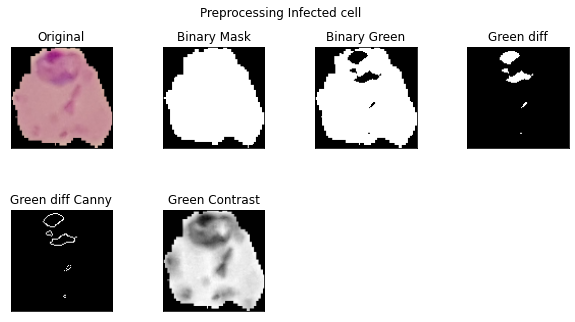

In [7]:
################ STACKING ##################
print("Stacking images")
def populateSet(x_in, y_in, x_out, y_out):
    for image, label in zip(x_in, y_in):
        green_diff, green_diff_canny, green_contrast = process_image(image, label, show=False)
        image_out = np.dstack((image, green_diff))
        image_out = np.dstack((image_out, green_diff_canny))
        x_out.append(image_out)
        y_out.append(label)

populateSet(x_train_image, y_train_label, x_train, y_train)
populateSet(x_valid_image, y_valid_label, x_valid, y_valid)
populateSet(x_test_image, y_test_label, x_test, y_test)

#SHOW PROCESSING
for index, label in enumerate(y_train_label): 
    if label == 1:
        process_image(x_train_image[index], label, show=True)
        break

### Creating NP-Arrays

Images lists are converted in np_arrays and normalized

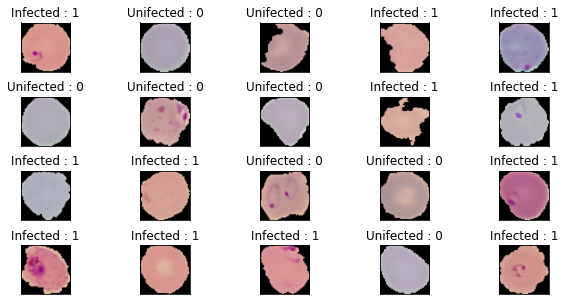

Shape of training image : (17636, 100, 100, 5)
Shape of validation image : (4410, 100, 100, 5)
Shape of testing image : (5512, 100, 100, 5)
Shape of training labels : (17636,)
Shape of validation labels : (4410,)
Shape of testing labels : (5512,)


In [8]:
############# CREATING NP ARRAY ###########
x_train = np.array(x_train)
y_train = np.array(y_train)
x_valid = np.array(x_valid)
y_valid = np.array(y_valid)
x_test = np.array(x_test)
y_test = np.array(y_test)

#del x_train_image
#del x_valid_image
#del x_test_image
#del y_train_label
#del y_valid_label
#del y_test_label
#del images
#del infected_images
#del uninfected_images
#gc.collect()

########### PLOTTING ###########
plt.figure(1, figsize=(10, 5))
plt.title('Random cells visualisation')
for i in range(20):
    r = np.random.randint(0, x_train.shape[0], 1)
    plt.subplot(4, 5, i + 1)
    plt.subplots_adjust(hspace=0.5, wspace=0.5)
    plt.imshow(cv2.cvtColor(x_train[r[0]][:, :, :3], cv2.COLOR_BGR2RGB))
    plt.title('{} : {}'.format(
        'Infected' if labels[r[0]] == 1 else 'Unifected', labels[r[0]]))
    plt.xticks([]), plt.yticks([])  # to hide tick values on X and Y axis
plt.savefig(figure_directory + "random_cells.pdf")
plt.show()

############# NOnRMALIZING ################
def normalize(dataset):
    dataset = dataset / 255
    dataset = dataset.reshape(dataset.shape[0], 100,100, 5)

normalize(x_train)
normalize(x_valid)
normalize(x_test)

print(f'Shape of training image : {x_train.shape}')
print(f'Shape of validation image : {x_valid.shape}')
print(f'Shape of testing image : {x_test.shape}')
print(f'Shape of training labels : {y_train.shape}')
print(f'Shape of validation labels : {y_valid.shape}')
print(f'Shape of testing labels : {y_test.shape}')

### Data Augmentation

In [9]:
# DATA GENERATOR

datagen = ImageDataGenerator(
    zoom_range=0.2,
    rotation_range=30,
    width_shift_range=0.2,
    height_shift_range=0.2,
    horizontal_flip=True,
    vertical_flip=True)

### CNN Model

In [10]:
# CREATING SEQUENTIAL MODEL
def CNNbuild(height, width, classes, channels):
    model=Sequential()
    model.add(Conv2D(16, (5,5), activation = 'relu', input_shape = (height, width, channels)))
    model.add(MaxPooling2D(2,2))
    model.add(BatchNormalization(axis =-1))
    model.add(Dropout(0.2))

    model.add(Conv2D(32, (3,3), activation = 'relu'))
    model.add(MaxPooling2D(2,2))
    model.add(BatchNormalization(axis = -1))
    model.add(Dropout(0.2))

    model.add(Conv2D(32, (3,3), activation = 'relu'))
    model.add(MaxPooling2D(2,2))
    model.add(BatchNormalization(axis = -1))
    
    model.add(Conv2D(64, (3,3), activation = 'relu'))
    model.add(MaxPooling2D(2,2))
    model.add(BatchNormalization(axis = -1))
    model.add(Dropout(0.2))
    
    model.add(Flatten())
        
    model.add(Dense(512, activation = 'relu'))
    model.add(BatchNormalization(axis = -1))
    model.add(Dropout(0.4))
    model.add(Dense(1, activation = 'sigmoid'))
    return model

model = CNNbuild(height = cell_dim, width = cell_dim, classes = n_classes, channels = channels)
adam = optimizers.Adam(learning_rate = 0.001)
model.compile(loss='binary_crossentropy', optimizer=adam, metrics=['accuracy'])
model.summary()
from IPython.display import SVG
from keras.utils import model_to_dot
#plot_model(model, to_file='model_plot.png', show_shapes=True, show_layer_names=True)
plot_model(model, to_file=figure_directory + "model.pdf", show_shapes=True, show_layer_names=True, dpi=300)

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d (Conv2D)              (None, 96, 96, 16)        2016      
_________________________________________________________________
max_pooling2d (MaxPooling2D) (None, 48, 48, 16)        0         
_________________________________________________________________
batch_normalization (BatchNo (None, 48, 48, 16)        64        
_________________________________________________________________
dropout (Dropout)            (None, 48, 48, 16)        0         
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 46, 46, 32)        4640      
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 23, 23, 32)        0         
_________________________________________________________________
batch_normalization_1 (Batch (None, 23, 23, 32)        1

In [12]:
##################### SETTINGS CALLBACKS ####################
model_file = model_directory + "{epoch:02d}-val_accuracy-{val_accuracy:.2f}-val_loss-{val_loss:.2f}.hdf5"
checkpoint = ModelCheckpoint(
    model_file, 
    monitor='val_accuracy', 
    save_best_only=True)

early_stopping = EarlyStopping(
    monitor='val_loss',
    patience=6,
    verbose=1,
    restore_best_weights=True)

reduce_lr = ReduceLROnPlateau(
    monitor='val_loss',
    factor=0.6,
    patience=1,
    verbose=1)

callbacks = [checkpoint, reduce_lr, early_stopping]

history = model.fit_generator(datagen.flow(x_train, y_train, batch_size=32), steps_per_epoch=len(x_train) / 32, validation_data=(x_valid, y_valid), epochs= n_epochs, verbose=1, shuffle=True, callbacks=callbacks)
#history = model.fit(x_train, y_train, batch_size=32, validation_data=(x_valid, y_valid), epochs=n_epochs, verbose=1, shuffle=True, callbacks=callbacks)

C:\Users\bhoom\AppData\Roaming\Python\Python38\site-packages\keras_preprocessing\image\numpy_array_iterator.py:129: UserWarning: NumpyArrayIterator is set to use the data format convention "channels_last" (channels on axis 3), i.e. expected either 1, 3, or 4 channels on axis 3. However, it was passed an array with shape (17636, 100, 100, 5) (5 channels).
  warnings.warn('NumpyArrayIterator is set to use the '
C:\Users\bhoom\anaconda3\lib\site-packages\tensorflow\python\keras\engine\training.py:1844: UserWarning: `Model.fit_generator` is deprecated and will be removed in a future version. Please use `Model.fit`, which supports generators.
  warnings.warn('`Model.fit_generator` is deprecated and '


Epoch 1/25
551/551 [==============================] - 2602s 5s/step - loss: 0.3731 - accuracy: 0.8714 - val_loss: 0.2300 - val_accuracy: 0.9288
Epoch 2/25
551/551 [==============================] - 1016s 2s/step - loss: 0.2842 - accuracy: 0.9064 - val_loss: 0.1986 - val_accuracy: 0.9469
Epoch 3/25
551/551 [==============================] - 1031s 2s/step - loss: 0.2658 - accuracy: 0.9110 - val_loss: 0.3862 - val_accuracy: 0.9256

Epoch 00003: ReduceLROnPlateau reducing learning rate to 0.0006000000284984708.
Epoch 4/25
551/551 [==============================] - 1003s 2s/step - loss: 0.2507 - accuracy: 0.9182 - val_loss: 0.1662 - val_accuracy: 0.9497
Epoch 5/25
551/551 [==============================] - 1010s 2s/step - loss: 0.2463 - accuracy: 0.9193 - val_loss: 0.1832 - val_accuracy: 0.9494

Epoch 00005: ReduceLROnPlateau reducing learning rate to 0.0003600000170990825.
Epoch 6/25
551/551 [==============================] - 1000s 2s/step - loss: 0.2385 - accuracy: 0.9215 - val_loss: 0.17

In [17]:
# Evaluate the model on the test data using `evaluate`
print("Evaluate on test data")
results = model.evaluate(x_test, y_test, batch_size=128)
print("test loss, test acc:", results)

# Generate predictions (probabilities -- the output of the last layer)
# on new data using `predict`
print("Generate predictions for 3 samples")
predictions = model.predict(x_test[:3])
print("predictions shape:", predictions.shape)
predictions

Evaluate on test data


NameError: name 'x_test' is not defined

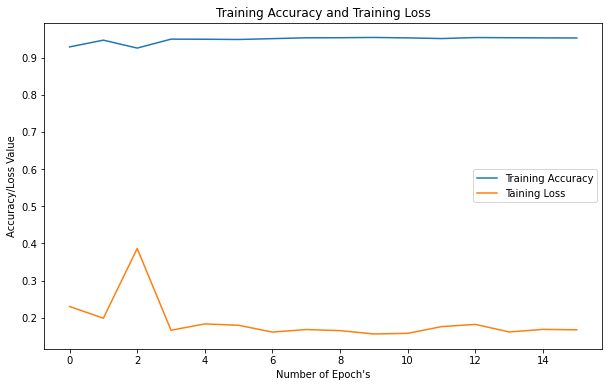

173/173 [==============================] - 33s 193ms/step - loss: 0.1589 - accuracy: 0.9507

LOSS : 0.1588674783706665
ACCURACY : 0.9506531357765198


In [14]:
################## EVALUATE ####################
plt.figure(figsize=(10, 6))
epochs = len(history.history['accuracy'])
plt.plot(range(epochs), history.history['val_accuracy'], label='Training Accuracy')
plt.plot(range(epochs), history.history['val_loss'], label='Taining Loss')
plt.xlabel("Number of Epoch's")
plt.ylabel('Accuracy/Loss Value')
plt.title('Training Accuracy and Training Loss')
plt.legend(loc="best")
plt.savefig(figure_directory + "accuracy_loss_graph.pdf")
plt.show()

################ METRICS ###################
metrics = model.evaluate(x_test, y_test, verbose=1)
cnn_predicted = model.predict(x_test)
cnn_predicted = cnn_predicted.reshape(cnn_predicted.shape[0])
cnn_predicted = np.round(cnn_predicted)
cnn_predicted = cnn_predicted.astype(int)
print()
print(f'LOSS : {metrics[0]}')
print(f'ACCURACY : {metrics[1]}')

In [15]:
#GRID SEARCH THOUGH CROSS VALIDATION
def best_performance_of(classifier, params, x_train, y_train, x_test, y_test, cross_validation = 10, save= False, feature_type = "neural_feature"):
    print("Grid search for: ", classifier)
    clf = GridSearchCV(classifier, params, n_jobs=multiprocessing.cpu_count(), cv=cross_validation, verbose=3)
    #Fit and search best param
    #with parallel_backend('threading'):
      #clf.fit(x_train, y_train)
    clf.fit(x_train, y_train)
    print("\nBest parameters set:")
    print(clf.best_params_)
    #used to print confusion matrix
    y_predict=clf.best_estimator_.predict(x_test)
    
    confusion_m = confusion_matrix(y_test, y_predict)
    index = ['bad','good']  
    columns = ['bad','good']
    cm_df = pd.DataFrame(confusion_m,columns,index)                      
    plt.figure(figsize=(10,6))
    heatmap = sns.heatmap(cm_df, annot=True, cmap="Blues")
    fig = heatmap.get_figure()
    fig.savefig(figure_directory + type(classifier).__name__ + "_" + feature_type + "_" + "matrix.pdf")
    plt.show()
    print("confusion matrix:")
    print(confusion_m)
    #Same information
    print("\nClassification report:")
    print(classification_report(y_test, y_predict))
    print("Best estimator score: ", clf.best_estimator_.score(x_test, y_test))
    #Store classifier if save is true
    if(save):
        score = int(clf.best_estimator_.score(x_test, y_test) * 100)
        print("store:" + "max" + str(score) +  ".sav")
        joblib.dump(clf.best_estimator_, classifiers_directory + "max" + str(score) +  ".sav")

### Extracting Neural Features and Training

Neural features extraction is performed in this way:

Train the CNN so that weight can be setted in optimal way

Remove dense level from CNN

Feed train data trough CNN and extract flatten level features (dim = 1024)

Pass features to Voting Classifier (SVM, Random Forest, KNN)

In [16]:
################ NEURAL FEATURE EXTRACTION #############
extract = Model(model.inputs, model.layers[-5].output)
x_train_neural_features = extract.predict(x_train)
x_valid_neural_features = extract.predict(x_valid)
x_test_neural_features = extract.predict(x_test)
print("Extracted features from flatten layer, shape:", x_train_neural_features.shape)

################# TRAIN CLASSIFIERS ON NEURAL FEATURES ################
grid_search = False
if grid_search:
    #### SVM
    tuned_parameters = [{'kernel': ['rbf'], 'gamma': [1e-3, 1e-4],
                        'C': [1, 10, 100]}]

    best_performance_of(svm.SVC(), tuned_parameters, 
                        x_train = x_train_neural_features, y_train = y_train, x_test = x_test_neural_features, y_test = y_test)

    #### RANDOM FOREST
    tuned_parameters = {"max_depth":[11,13,15,17,20]}
    best_performance_of(RandomForestClassifier(random_state=0), tuned_parameters, 
                        x_train = x_train_neural_features, y_train = y_train, x_test = x_test_neural_features, y_test = y_test)
    
    #### KNN
    tuned_parameters = {"n_neighbors": [3,5,9,11,15,17,19],}
    best_performance_of(KNeighborsClassifier(), tuned_parameters,
                        x_train = x_train_neural_features, y_train = y_train, x_test = x_test_neural_features, y_test = y_test)

####### SVM
svm_neural = svm.SVC(gamma=0.001, C=1, kernel='rbf') # [10, 0.001] V [1, 0.001]
####### RANDOM FOREST
rf_neural = RandomForestClassifier(max_depth=16, random_state=0)
####### KNN
knn_neural = KNeighborsClassifier(n_neighbors = 5) #5

################### MAJORITY NEURAL CLASSIFIER ####################
print("SVM/RF/KNN training on neural features...")
multi_neural = VotingClassifier(estimators=[
       ('svm', svm_neural), ('rf', rf_neural), ('knn', knn_neural)],
       voting='hard', weights=[1.2,1,1],
       flatten_transform=True, n_jobs=-1)
multi_neural = multi_neural.fit(x_train_neural_features, y_train)
multi_neural_predicted = multi_neural.predict(x_test_neural_features)
print("SVM/RF/KNN neural features accuracy score:", accuracy_score(y_test, multi_neural_predicted))

Extracted features from flatten layer, shape: (17636, 1024)
SVM/RF/KNN training on neural features...
SVM/RF/KNN neural features accuracy score: 0.9533744557329463


### Visualisation

2D visualisation is performed in this way:

Select number of features to display

Reduce dimensionality to lower dimensions (50) trough PCA algorithm

Reduce dimensionality to 2 dimensions trough T-SNE algorithm

Plot the result

Features visualisation: PDA -> T-SNE
Dataframe size: (10000, 1025)
PCA shape: (10000, 50)
T-SNE shape: (10000, 2)


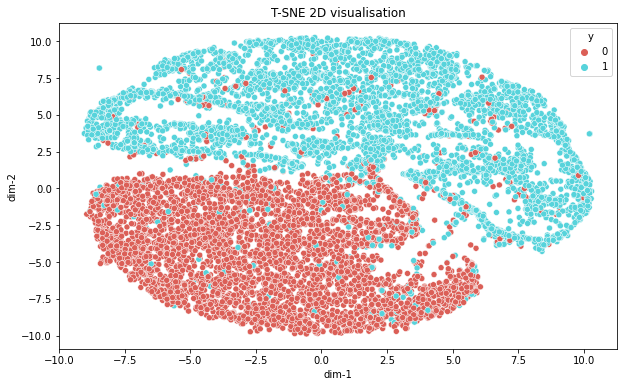

In [17]:
################### PCA T-SNE AND PLOTTING ################# 
print("Features visualisation: PDA -> T-SNE")
feature_number = 10000
x_visual_features = x_train_neural_features[:feature_number]
y_visual_features = y_train[:feature_number]
#features_columns = ['pixel' + str(i) for i in range(x_train_neural_features.shape[1])]
df = pd.DataFrame(x_visual_features) #, columns=features_columns)
df['y'] = y_visual_features
#df['label'] = df['y'].apply(lambda i: str(i))
print('Dataframe size:', df.shape)

pca = PCA(n_components=50)
pca_result = pca.fit_transform(df)
print("PCA shape:", pca_result.shape)

tsne = TSNE(n_components=2, verbose=0, perplexity=40, n_iter=300)
tsne_pca_result = tsne.fit_transform(df)
print("T-SNE shape:", tsne_pca_result.shape)

df['dim-1'] = tsne_pca_result[:,0]
df['dim-2'] = tsne_pca_result[:,1] 

plt.figure(figsize=(10,6))
plt.title("T-SNE 2D visualisation")
sns.scatterplot(
    x="dim-1", y="dim-2",
    hue="y",
    palette=sns.color_palette("hls", 2),
    data=df,
    legend="full",
    alpha=1
)
plt.savefig(figure_directory + "cells_visualisation_2D.pdf")
plt.show()


# WAIT AND DESTROY
cv2.waitKey()
cv2.destroyAllWindows()

### ResNet-50

In [46]:
import cv2 # cv2 for reading and processing the images
import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# libraries for plotting
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
from pylab import *
import seaborn as sns

from sklearn.model_selection import train_test_split
# Keras libraries
from keras import layers
from keras import models
from keras import optimizers
from keras.preprocessing.image import ImageDataGenerator
from keras.applications import ResNet50
from keras.utils import to_categorical
from keras.layers import Conv2D,MaxPooling2D,Dense,Flatten,Dropout
from keras.optimizers import Adam
# other libraries
import gc
import random
import os

from keras import callbacks
from keras import preprocessing
from keras.preprocessing.image import ImageDataGenerator
from keras.layers import Conv2D, MaxPooling2D, Dense, Flatten, Dropout, BatchNormalization
from keras.callbacks import ModelCheckpoint, EarlyStopping, TensorBoard, ReduceLROnPlateau
# Any results you write to the current directory are saved as output.

In [20]:
print(os.listdir("C://Users//bhoom//Desktop//Projects//Untitled Folder 1//cell_images//cell_images"))

['Parasitized', 'Uninfected']


In [21]:
img_height = 112
img_width = 112
img_channels = 3
np_random_seed = 41

#### Function to read the images from the given directory and returns Numpy array of X, y and array of labels (names of the directory)
The function reads from the given directory, it considers each immidiate sub-directory as a lable. Parameters: <br>
data_dir (String): Path to the directory <br>
image_dims (tuple): Dimensions of the image (length, breadth). <br>
num_of_imgs (int): Total number of images to be loaded, if None all the images are loaded. Equal amount of images from each <br>sub-directory are loaded. eg: If input is 30 and there are three subdirectories then 10 images from each directory are loaded <br> convert_to_categorical (boolean): If true then y is converted to one hot vector else a single np array of series of number for each lable starting with 0 <br>
Returns: <br>
int: Description of return value  

In [22]:
def read_and_process_images(data_dir, image_dims = (56,56), num_of_imgs = None, convert_to_categorical = True):
   
   
    # initialize empty python arrays for X and y
    X = []
    y = []
    
    num_of_img_per_class = 0
    labels = [ name for name in os.listdir(data_dir) if os.path.isdir(os.path.join(data_dir, name)) ]
    if num_of_imgs is not None:
        num_of_img_per_class = int(round(num_of_imgs/len(labels)))
        
    print('num_of_img_per_class : '+str(num_of_img_per_class if num_of_img_per_class > 0 else 'All' ))
    
    lable_count = 0
    #importing the Parasitized images
    for label in labels:
        size = 0
        print('Importing lable : '+str(label))
        for imgpath in os.listdir(data_dir+'/'+label):
            try:
                X.append(cv2.resize(cv2.imread(data_dir+'/'+label+'/'+imgpath, cv2.IMREAD_COLOR), image_dims, interpolation=cv2.INTER_CUBIC))
                y.append(lable_count)
            except BaseException as err:
                print('Error readding file :"'+label+'/'+imgpath+'", '+str(err))
            
            size += 1
            
            if num_of_img_per_class == size :
                break
        print('Imported lable : '+str(label))
        lable_count =+ 1
    
    # converting the python array into Numpy array
    X_np = np.array(X)
    y_temp = np.array(y)
    
    # converting the y variables to categorical
    if(convert_to_categorical) :
        y_np = to_categorical(y_temp,len(labels))
        del y_temp
        gc.collect()
    else:
        y_np = y_temp
    print ('converted to np arrays')
    
    # deleting the python arrays as they are no longer required and it would reduce the memory
    del X
    del y
    gc.collect()
    print ('deleted temp arrays')

    # Normalizing and converting the data into float
    X_np.astype('float32')/255.0
    print ('data normalized')

    return X_np, y_np, labels

#### Call the above defined function to load the images

In [37]:
np.random.seed(np_random_seed)
X, y, lables = read_and_process_images('C://Users//bhoom//Desktop//Projects//Untitled Folder 1//cell_images//cell_images', image_dims=(img_height,img_width))
#X_train,y_train, X_test,  y_test,X_valid, y_valid = train_test_split(X, y, test_size=0.1,valid_size=0.1,shuffle = True,stratify = y)
# = train_test_split(X, y, test_size=0.1,shuffle = True,stratify = y)
X_train, X_rem, y_train, y_rem = train_test_split(X,y, train_size=0.8)

test_size = 0.5
X_valid, X_test, y_valid, y_test = train_test_split(X_rem,y_rem, test_size=0.5)
print('X_train Shape : '+str(X_train.shape))
print('X_test Shape : '+str(X_test.shape))
print('y_train Shape : '+str(y_train.shape))
print('y_test Shape : '+str(y_test.shape))
print('X_valid Shape : '+str(X_valid.shape))
print('y_valid Shape : '+str(y_valid.shape))

num_of_img_per_class : All
Importing lable : Parasitized
Error readding file :"Parasitized/Thumbs.db", OpenCV(4.5.3) C:\Users\runneradmin\AppData\Local\Temp\pip-req-build-q3d_8t8e\opencv\modules\imgproc\src\resize.cpp:4051: error: (-215:Assertion failed) !ssize.empty() in function 'cv::resize'

Imported lable : Parasitized
Importing lable : Uninfected
Error readding file :"Uninfected/Thumbs.db", OpenCV(4.5.3) C:\Users\runneradmin\AppData\Local\Temp\pip-req-build-q3d_8t8e\opencv\modules\imgproc\src\resize.cpp:4051: error: (-215:Assertion failed) !ssize.empty() in function 'cv::resize'

Imported lable : Uninfected
converted to np arrays
deleted temp arrays
data normalized
X_train Shape : (22046, 112, 112, 3)
X_test Shape : (2756, 112, 112, 3)
y_train Shape : (22046, 2)
y_test Shape : (2756, 2)
X_valid Shape : (2756, 112, 112, 3)
y_valid Shape : (2756, 2)


#### Viewing images

Displays the images from the given data X <br>
Parameters: <br>
X (numpy.array) : Numpy array of images <br>
start_idx(int) : Index from where we start viewing the, make sure that the number doesnot exceed the length of the X_train <br>
num_imgs (int) : Total number of images that have to be displayed <br>
img_per_row (int) : Number of images that have to be displayed per row

In [38]:
def show_images(X, y, start_idx = 0,num_imgs = 10, img_per_row = 5):

    num_rows = int(num_imgs/img_per_row) + 1
    plt.figure(figsize = (18,4 * num_rows))
    for i in range(1,num_imgs+1):
        plt.subplot(num_rows,img_per_row,i)
        plt.title(str(lables[np.argmax(y[start_idx])]))
        plt.imshow(X_train[start_idx])
        start_idx += 1

In [39]:
datagen = ImageDataGenerator(
    zoom_range=0.2,
    rotation_range=30,
    width_shift_range=0.2,
    height_shift_range=0.2,
    horizontal_flip=True,
    vertical_flip=True)

In [40]:
from keras.applications.resnet50 import ResNet50
from keras.models import Model
import keras
restnet = ResNet50(include_top=False, weights='imagenet', input_shape=(img_height,img_width,3))
output = restnet.layers[-1].output
output = keras.layers.Flatten()(output)
restnet = Model(restnet.input, outputs =output)
for layer in restnet.layers:
    layer.trainable = False
restnet.summary()

Model: "model_2"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_3 (InputLayer)            [(None, 112, 112, 3) 0                                            
__________________________________________________________________________________________________
conv1_pad (ZeroPadding2D)       (None, 118, 118, 3)  0           input_3[0][0]                    
__________________________________________________________________________________________________
conv1_conv (Conv2D)             (None, 56, 56, 64)   9472        conv1_pad[0][0]                  
__________________________________________________________________________________________________
conv1_bn (BatchNormalization)   (None, 56, 56, 64)   256         conv1_conv[0][0]                 
____________________________________________________________________________________________

In [42]:
from keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, Dropout, InputLayer
from keras.models import Sequential
from keras import optimizers
model = Sequential()
model.add(restnet)
model.add(Dense(512, activation='relu', input_dim=(img_height,img_width,3)))
model.add(Dropout(0.3))
model.add(Dense(512, activation='relu'))
model.add(Dropout(0.3))
model.add(Dense(2, activation='sigmoid'))
model.compile(loss='binary_crossentropy',
              optimizer=optimizers.RMSprop(lr=2e-5),
              metrics=['accuracy'])
model.summary()

Model: "sequential_5"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
model_2 (Functional)         (None, 32768)             23587712  
_________________________________________________________________
dense_15 (Dense)             (None, 512)               16777728  
_________________________________________________________________
dropout_10 (Dropout)         (None, 512)               0         
_________________________________________________________________
dense_16 (Dense)             (None, 512)               262656    
_________________________________________________________________
dropout_11 (Dropout)         (None, 512)               0         
_________________________________________________________________
dense_17 (Dense)             (None, 2)                 1026      
Total params: 40,629,122
Trainable params: 17,041,410
Non-trainable params: 23,587,712
_________________________________

In [48]:
import glob
############# INPUT CONFIGURATION ###########
dataset_base_directory = "C://Users//bhoom//Desktop//Projects//Untitled Folder 1//cell_images"
cells_folders = os.listdir(dataset_base_directory)
print("Cells folders:", cells_folders)
infected_folder = dataset_base_directory + "/Parasitized"
uninfected_folder = dataset_base_directory + "/Uninfected"
infected_images = glob.glob(infected_folder + "/*.png")
uninfected_images = glob.glob(uninfected_folder + "/*.png")
infected_number = len(infected_images)
uninfected_number = len(uninfected_images)
print('# Infected fotos: ', infected_number)
print('# Infected fotos: ', uninfected_number)

############# OUTPUT CONFIGURATION ###########
def create_new_folder(directory):
    if not os.path.exists(directory):
        try:
            os.mkdir(directory)
        except:
            print("Could not create {} directory".format(directory))
output_directory = r"output/"
figure_directory = "output/figures/"
models_directory = output_directory + r"models/"
classifiers_directory = output_directory + r"classifiers/"
logs_directory = output_directory + r"logs/"
model_directory = models_directory + time.strftime('%Y-%m-%d %H-%M-%S') + "/"
log_directory = logs_directory + time.strftime('%Y-%m-%d %H-%M-%S') + "/"

create_new_folder(output_directory)
create_new_folder(figure_directory)
create_new_folder(models_directory)
create_new_folder(logs_directory)
create_new_folder(model_directory)
create_new_folder(classifiers_directory)
create_new_folder(log_directory)
print("Output folders created under:", output_directory)

Cells folders: ['cell_images', 'Parasitized', 'Uninfected']
# Infected fotos:  13779
# Infected fotos:  13779
Output folders created under: output/


In [49]:
##################### SETTINGS CALLBACKS ####################
model_file = model_directory + "{epoch:02d}-val_accuracy-{val_accuracy:.2f}-val_loss-{val_loss:.2f}.hdf5"
checkpoint = ModelCheckpoint(
    model_file, 
    monitor='val_accuracy', 
    save_best_only=True)

early_stopping = EarlyStopping(
    monitor='val_loss',
    patience=6,
    verbose=1,
    restore_best_weights=True)

reduce_lr = ReduceLROnPlateau(
    monitor='val_loss',
    factor=0.6,
    patience=1,
    verbose=1)

callbacks = [checkpoint, reduce_lr, early_stopping]
#his = model.fit(X_train,y_train,batch_size=32, epochs= 5, validation_split=0.2)
history = model.fit_generator(datagen.flow(X_train, y_train, batch_size=32), steps_per_epoch=len(X_train) / 32, validation_data=(X_valid, y_valid), epochs= 15, verbose=1, shuffle=True, callbacks=callbacks)
#history = model.fit(x_train, y_train, batch_size=32, validation_data=(x_valid, y_valid), epochs=n_epochs, verbose=1, shuffle=True, callbacks=callbacks)

C:\Users\bhoom\anaconda3\lib\site-packages\tensorflow\python\keras\engine\training.py:1844: UserWarning: `Model.fit_generator` is deprecated and will be removed in a future version. Please use `Model.fit`, which supports generators.
  warnings.warn('`Model.fit_generator` is deprecated and '


Epoch 1/15
688/688 [==============================] - 925s 1s/step - loss: 0.4957 - accuracy: 0.8074 - val_loss: 0.2951 - val_accuracy: 0.8726
Epoch 2/15
688/688 [==============================] - 967s 1s/step - loss: 0.3310 - accuracy: 0.8695 - val_loss: 0.2632 - val_accuracy: 0.8864
Epoch 3/15
688/688 [==============================] - 914s 1s/step - loss: 0.3134 - accuracy: 0.8777 - val_loss: 0.2725 - val_accuracy: 0.8792

Epoch 00003: ReduceLROnPlateau reducing learning rate to 1.1999999696854501e-05.
Epoch 4/15
688/688 [==============================] - 812s 1s/step - loss: 0.3019 - accuracy: 0.8881 - val_loss: 0.2552 - val_accuracy: 0.8911
Epoch 5/15
688/688 [==============================] - 825s 1s/step - loss: 0.2883 - accuracy: 0.8918 - val_loss: 0.2315 - val_accuracy: 0.9002
Epoch 6/15
688/688 [==============================] - 782s 1s/step - loss: 0.2874 - accuracy: 0.8957 - val_loss: 0.2690 - val_accuracy: 0.8846

Epoch 00006: ReduceLROnPlateau reducing learning rate to 7.

In [50]:
accuracy = model.evaluate(X_test, y_test, verbose=1)
print('\n', 'Test_Accuracy:-', accuracy[1])

87/87 [==============================] - 88s 1s/step - loss: 0.1939 - accuracy: 0.9271

 Test_Accuracy:- 0.9270682334899902


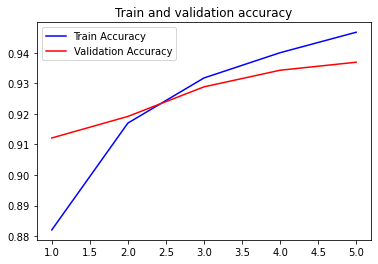

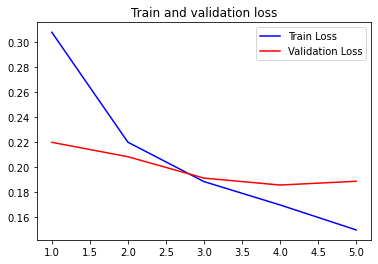

In [51]:
train_accs = his.history['accuracy']
train_losses = his.history['loss']
val_accs = his.history['val_accuracy']
val_losses = his.history['val_loss']

epochs = range(1, len(train_accs)+1)

plt.plot(epochs,train_accs, 'b', label='Train Accuracy')
plt.plot(epochs,val_accs, 'r', label='Validation Accuracy')
plt.title('Train and validation accuracy')
plt.legend()

plt.figure()

plt.plot(epochs,train_losses, 'b', label='Train Loss')
plt.plot(epochs,val_losses, 'r', label='Validation Loss')
plt.title('Train and validation loss')
plt.legend()

plt.show()

we will now fine-tune Transfer learning with image augmentation using ResNet50. We do this by unfreezing a few of the last convolution blocks while keeping the first early conv blocks frozen. This will help us to learn very generic features using early layers. Higher layers of pre-trained models will be trainable or fine-tuned.

In [52]:
restnet.trainable = True
set_trainable = False
for layer in restnet.layers:
    if layer.name in ['res5c_branch2b', 'res5c_branch2c', 'activation_97']:
        set_trainable = True
    if set_trainable:
        layer.trainable = True
    else:
        layer.trainable = False
layers = [(layer, layer.name, layer.trainable) for layer in restnet.layers]
pd.DataFrame(layers, columns=['Layer Type', 'Layer Name', 'Layer Trainable'])

,Layer Type,Layer Name,Layer Trainable
0,<tensorflow.python.keras.engine.input_layer.In...,input_3,False
1,<tensorflow.python.keras.layers.convolutional....,conv1_pad,False
2,<tensorflow.python.keras.layers.convolutional....,conv1_conv,False
3,<tensorflow.python.keras.layers.normalization_...,conv1_bn,False
4,<tensorflow.python.keras.layers.core.Activatio...,conv1_relu,False
...,...,...,...
171,<tensorflow.python.keras.layers.convolutional....,conv5_block3_3_conv,False
172,<tensorflow.python.keras.layers.normalization_...,conv5_block3_3_bn,False
173,<tensorflow.python.keras.layers.merge.Add obje...,conv5_block3_add,False
174,<tensorflow.python.keras.layers.core.Activatio...,conv5_block3_out,False


In [53]:
from keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, Dropout, InputLayer
from keras.models import Sequential
from keras import optimizers
model_finetuned = Sequential()
model_finetuned.add(restnet)
model_finetuned.add(Dense(512, activation='relu', input_dim=(img_height,img_width,3)))
model_finetuned.add(Dropout(0.3))
model_finetuned.add(Dense(512, activation='relu'))
model_finetuned.add(Dropout(0.3))
model_finetuned.add(Dense(1, activation='sigmoid'))
model_finetuned.compile(loss='binary_crossentropy',
              optimizer=optimizers.RMSprop(lr=1e-5),
              metrics=['accuracy'])
model_finetuned.summary()

Model: "sequential_6"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
model_2 (Functional)         (None, 32768)             23587712  
_________________________________________________________________
dense_18 (Dense)             (None, 512)               16777728  
_________________________________________________________________
dropout_12 (Dropout)         (None, 512)               0         
_________________________________________________________________
dense_19 (Dense)             (None, 512)               262656    
_________________________________________________________________
dropout_13 (Dropout)         (None, 512)               0         
_________________________________________________________________
dense_20 (Dense)             (None, 1)                 513       
Total params: 40,628,609
Trainable params: 17,040,897
Non-trainable params: 23,587,712
_________________________________

In [57]:
history1 = model_finetuned.fit_generator(datagen.flow(X_train, y_train, batch_size=32), steps_per_epoch=len(X_train) / 32, validation_data=(X_valid, y_valid), epochs= 1, verbose=1, shuffle=True, callbacks=callbacks)

MemoryError: Unable to allocate 3.09 GiB for an array with shape (22046, 112, 112, 3) and data type float32

In [58]:
accuracy = model_finetuned.evaluate(X_test, y_test, verbose=1)
print('\n', 'Test_Accuracy:-', accuracy[1])

ValueError: in user code:

    C:\Users\bhoom\anaconda3\lib\site-packages\tensorflow\python\keras\engine\training.py:1233 test_function  *
        return step_function(self, iterator)
    C:\Users\bhoom\anaconda3\lib\site-packages\tensorflow\python\keras\engine\training.py:1224 step_function  **
        outputs = model.distribute_strategy.run(run_step, args=(data,))
    C:\Users\bhoom\anaconda3\lib\site-packages\tensorflow\python\distribute\distribute_lib.py:1259 run
        return self._extended.call_for_each_replica(fn, args=args, kwargs=kwargs)
    C:\Users\bhoom\anaconda3\lib\site-packages\tensorflow\python\distribute\distribute_lib.py:2730 call_for_each_replica
        return self._call_for_each_replica(fn, args, kwargs)
    C:\Users\bhoom\anaconda3\lib\site-packages\tensorflow\python\distribute\distribute_lib.py:3417 _call_for_each_replica
        return fn(*args, **kwargs)
    C:\Users\bhoom\anaconda3\lib\site-packages\tensorflow\python\keras\engine\training.py:1217 run_step  **
        outputs = model.test_step(data)
    C:\Users\bhoom\anaconda3\lib\site-packages\tensorflow\python\keras\engine\training.py:1185 test_step
        self.compiled_loss(
    C:\Users\bhoom\anaconda3\lib\site-packages\tensorflow\python\keras\engine\compile_utils.py:203 __call__
        loss_value = loss_obj(y_t, y_p, sample_weight=sw)
    C:\Users\bhoom\anaconda3\lib\site-packages\tensorflow\python\keras\losses.py:152 __call__
        losses = call_fn(y_true, y_pred)
    C:\Users\bhoom\anaconda3\lib\site-packages\tensorflow\python\keras\losses.py:256 call  **
        return ag_fn(y_true, y_pred, **self._fn_kwargs)
    C:\Users\bhoom\anaconda3\lib\site-packages\tensorflow\python\util\dispatch.py:201 wrapper
        return target(*args, **kwargs)
    C:\Users\bhoom\anaconda3\lib\site-packages\tensorflow\python\keras\losses.py:1608 binary_crossentropy
        K.binary_crossentropy(y_true, y_pred, from_logits=from_logits), axis=-1)
    C:\Users\bhoom\anaconda3\lib\site-packages\tensorflow\python\util\dispatch.py:201 wrapper
        return target(*args, **kwargs)
    C:\Users\bhoom\anaconda3\lib\site-packages\tensorflow\python\keras\backend.py:4979 binary_crossentropy
        return nn.sigmoid_cross_entropy_with_logits(labels=target, logits=output)
    C:\Users\bhoom\anaconda3\lib\site-packages\tensorflow\python\util\dispatch.py:201 wrapper
        return target(*args, **kwargs)
    C:\Users\bhoom\anaconda3\lib\site-packages\tensorflow\python\ops\nn_impl.py:173 sigmoid_cross_entropy_with_logits
        raise ValueError("logits and labels must have the same shape (%s vs %s)" %

    ValueError: logits and labels must have the same shape ((None, 1) vs (None, 2))
